## Imports

In [240]:
import numpy as np
import matplotlib.pyplot as plt
import os
from os import read
import pandas as pd
import math

def checkNotEmpty(input_array):
    for x in input_array:
        if float(x) > 0:
            return True
    return False

def getAverage(input_array):
    acc = 0.0
    for x in input_array:
        acc+=x
    return acc / len(input_array)

def getWindowFrameFromDir(source_dir, window_size):
    cache_windows = []
    ipc_windows = []
    for subdir, dirs, files in os.walk(source_dir):
        for dir in dirs:
            cache = []
            ipc = []
            ipc_window = []
            cache_window= []
            for filename in os.listdir(os.path.join(subdir, dir)):
                f = os.path.join(subdir, dir, filename)
                actualfile = open(f,'r')
                if (filename[:3] == "ipc"):
                    ipc = actualfile.readlines()
                else:
                    cache = actualfile.readlines()
            dipc = window_size-len(ipc)
            dcache = window_size-len(cache)
            if dipc > 0:
                for x in range(dipc):
                    ipc.append('0')
            if dcache > 0:
                for x in range(dcache):
                    cache.append('0')
            if (checkNotEmpty(cache) and checkNotEmpty(ipc)):
                for x in range(0, window_size):
                    ipc_window.append(float(ipc[x]))
                for x in range(0, window_size):
                    # let's normalize cache access to IPC
                    cache_window.append(float(cache[x])/1000000)
                cache_windows.append(getAverage(cache_window))
                ipc_windows.append(getAverage(ipc_window))
    dataframe = pd.DataFrame(list(zip(ipc_windows, cache_windows)), columns=['avg_ipc', 'avg_cache'])
    return dataframe


## Data frame construction

In [275]:
bench = "../results/benchmarks/" # change me if necessary
normal = "../results/pcf2bdf/normal_v2/"
attack = "../results/pcf2bdf/attack_v2/"
window_size = 50 # change me if necessary

In [251]:
df_bench  = getWindowFrameFromDir(bench,window_size)
df_normal = getWindowFrameFromDir(normal,window_size)
df_bench


,avg_ipc,avg_cache
0,0.3284,1.619419
1,0.1260,0.763439
2,0.4010,0.552706
3,0.3478,0.546925
4,0.1040,0.244266
...,...,...
1775,0.2804,3.940152
1776,0.4166,1.086288
1777,0.3934,1.500051
1778,0.2824,0.667474


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


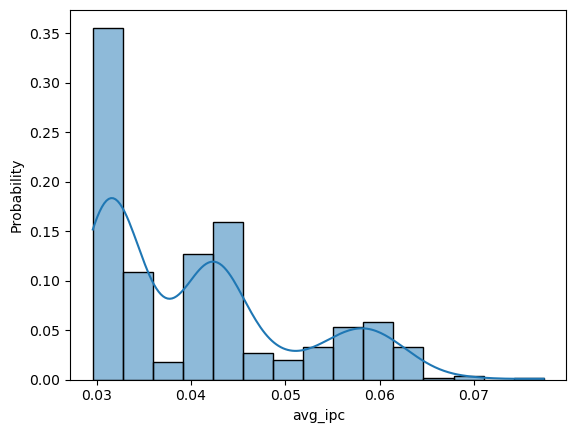

In [276]:
df_attack = getWindowFrameFromDir(attack,window_size)
import seaborn as sns
sns.histplot(df_attack['avg_ipc'], kde=True, stat='probability')

In [279]:
df_merged = pd.concat([df_normal, df_attack[:100]], ignore_index=True)
df_merged

,avg_ipc,avg_cache
0,0.2590,0.155349
1,0.7756,0.351781
2,0.1766,0.137491
3,0.1620,0.137451
4,0.6936,0.438684
...,...,...
623,0.0310,0.054578
624,0.0300,0.054896
625,0.0318,0.055664
626,0.0330,0.055407


## Unsupervised stuff

### Categories visualization

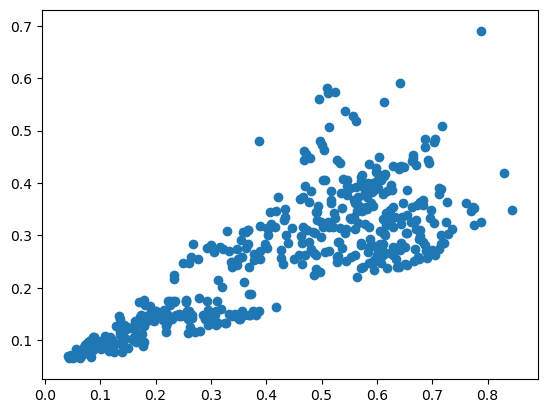

In [245]:
x_axis = df_merged["avg_ipc"]  
y_axis = df_merged["avg_cache"]  

# Plotting
plt.scatter(x_axis, y_axis)
plt.show()

### K-means (2)

/home/jeferson/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


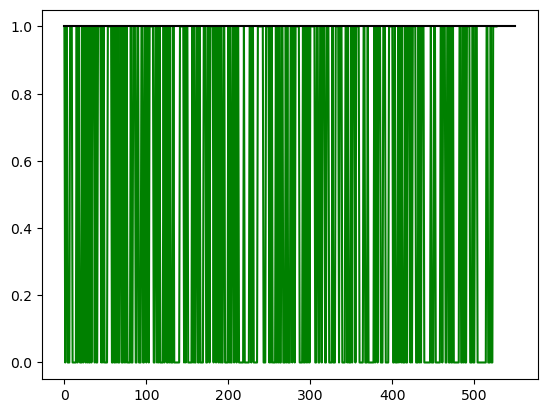

In [280]:
from sklearn import datasets
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2)

# Fitting Model
model.fit(df_merged)

# Predicting using the whole dataset
whole_prediction = model.predict(df_merged)
attack_prediction = model.predict(df_attack)
normal_prediction = model.predict(df_normal)
bench_prediction = model.predict(df_bench)


plt.plot(normal_prediction, c='green')
plt.plot(attack_prediction, c='black')

In [247]:
def create_reference(df, label):
    reference = []
    for y in (df.index):
        reference.append(label)
    return(reference)
def false_positive_rate(reference, prediction):
    reference = np.array(reference)
    prediction = np.array(prediction)
    false_positives = np.sum(np.logical_and(reference == -1, prediction == 1))
    true_negatives = np.sum(reference == -1)
    return false_positives / (false_positives + true_negatives)

def false_negative_rate(reference, prediction):
    reference = np.array(reference)
    prediction = np.array(prediction)
    false_negatives = np.sum(np.logical_and(reference == 1, prediction == -1))
    true_positives = np.sum(reference == 1)
    return false_negatives / (false_negatives + true_positives)



### One-class SVM

In [274]:
from sklearn import datasets
from sklearn import svm
from sklearn.svm import OneClassSVM

X_train = df_normal


clf = OneClassSVM(gamma='scale', kernel='rbf', nu=0.07).fit(X_train)
#TODO: explore nu value https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM.decision_function
Y_pred_attack = clf.predict(df_attack)
Y_pred_normal = clf.predict(df_normal)
Y_pred_bench = clf.predict(df_bench)

y_train_normal = create_reference(df_normal, 1)
y_train_attack = create_reference(df_attack, -1)
y_train_bench = create_reference(df_bench, -1)


y_train = np.concatenate([y_train_normal, y_train_attack, y_train_bench])
y_pred = np.concatenate([Y_pred_normal, Y_pred_attack, Y_pred_bench])


print("[Full set] fp = ", round(false_positive_rate(y_train, y_pred)*100,2), "% fn = ", round(false_negative_rate(y_train, y_pred)*100,2), "%")






[Full set] fp =  4.66 % fn =  6.55 %
